<a href="https://colab.research.google.com/github/Yihan-Zhang1217/COMP0050-2025/blob/main/0051.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests

In [12]:


# -------------------------
# 1. Data Import and Preprocessing
# -------------------------
start_date = '2023-01-01'
end_date   = '2023-12-31'

# Download SPTL ETF data from Yahoo Finance for 2023
sptl_data = yf.download('SPTL', start=start_date, end=end_date)
sptl_data.reset_index(inplace=True)
# If columns are a MultiIndex, flatten them:
if isinstance(sptl_data.columns, pd.MultiIndex):
    sptl_data.columns = sptl_data.columns.get_level_values(0)

# Use 'Adj Close' if available; otherwise, 'Close'
if 'Adj Close' in sptl_data.columns:
    sptl_data = sptl_data[['Date', 'Adj Close']].rename(columns={'Adj Close':'Price'})
else:
    sptl_data = sptl_data[['Date', 'Close']].rename(columns={'Close':'Price'})

# Download EFFR data from FRED using your API key via a direct API call
fred_api_key = '4cdbc9b60ac3207f4e75cbfbcccae47b'
fred_url = "https://api.stlouisfed.org/fred/series/observations"
params = {
    'series_id': 'EFFR',
    'api_key': fred_api_key,
    'file_type': 'json',
    'observation_start': start_date,
    'observation_end': end_date
}

response = requests.get(fred_url, params=params)
data_json = response.json()

# Create a DataFrame from the observations
effr_data = pd.DataFrame(data_json['observations'])
# If columns are a MultiIndex, flatten them (usually not the case here)
if isinstance(effr_data.columns, pd.MultiIndex):
    effr_data.columns = effr_data.columns.get_level_values(0)

# Rename and convert columns
effr_data = effr_data[['date', 'value']].rename(columns={'date': 'Date', 'value': 'EFFR'})
effr_data['Date'] = pd.to_datetime(effr_data['Date'])
effr_data['EFFR'] = pd.to_numeric(effr_data['EFFR'], errors='coerce')

# -------------------------
# 2. Merge SPTL and EFFR Data on 'Date'
# -------------------------
data = pd.merge(sptl_data, effr_data, on='Date', how='inner')

# -------------------------
# 3. Further Preprocessing
# -------------------------
# Adjust the annual risk-free rate (EFFR) to a daily rate using day count ≈ 1/252
data['rft'] = data['EFFR'] * (1/252)

# Compute daily price return and excess return:
data['price_return'] = data['Price'].pct_change()
data['excess_return'] = data['price_return'] - data['rft']
data.dropna(inplace=True)

print("Data sample:")
print(data.head())


[*********************100%***********************]  1 of 1 completed


Data sample:
        Date      Price  EFFR       rft  price_return  excess_return
1 2023-01-04  27.669300  4.33  0.017183      0.012530      -0.004653
2 2023-01-05  27.780348  4.33  0.017183      0.004013      -0.013169
3 2023-01-06  28.261553  4.33  0.017183      0.017322       0.000139
4 2023-01-09  28.400366  4.33  0.017183      0.004912      -0.012271
5 2023-01-10  27.983938  4.33  0.017183     -0.014663      -0.031845


In [7]:
import matplotlib.pyplot as plt


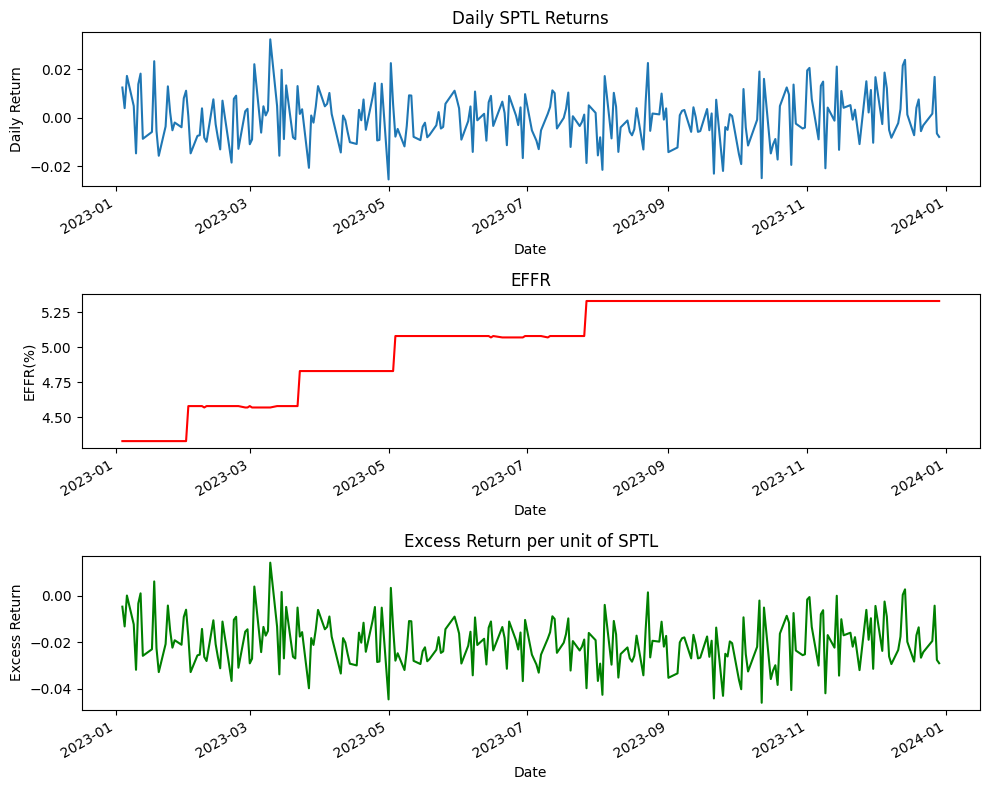

In [13]:
data.set_index('Date', inplace=True)

# 1. Plot the daily SPTL returns
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
data['price_return'].plot()
plt.title('Daily SPTL Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')

# 2. plot EFFR
plt.subplot(3,1,2)
data['EFFR'].plot(color='red')
plt.title('EFFR')
plt.xlabel('Date')
plt.ylabel('EFFR(%)')

# 3. Plot the excess return
plt.subplot(3,1,3)
data['excess_return'].plot(color='green')
plt.title('Excess Return per unit of SPTL')
plt.xlabel('Date')
plt.ylabel('Excess Return')

plt.tight_layout()
plt.show()

Q2 EWMA trend-following strategy and Bollinger Bands mean-reversion

In [15]:
# EWMAs trend-following strategy

# signal generation
def ewma_signals(df,short_window, long_window):
  df = df.copy()

  df['ewma_short']=df['Price'].ewm(span=short_window, adjust=False).mean()
  df['ewma_long']=df['Price'].ewm(span=long_window, adjust=False).mean()
  df['signal']=0
  df.loc[df['ewma_short']>df['ewma_long'],'signal']=1
  df.loc[df['ewma_short']<df['ewma_long'],'signal']=-1
  return df

# Bollinger_bands mean-reversion trading strategy (Non-trend following)
def bb_signals(df,window,n_std):
  df = df.copy()
  df['bb_MA'] = df['Price'].rolling(window).mean()
  df['std']=df['Price'].rolling(window).std()
  df['upper_band']=df['bb_MA']+n_std*df['std']
  df['lower_band']=df['bb_MA']-n_std*df['std']
  df['signal']=0
  df.loc[df['Price']<df['lower_band'],'signal']=1
  df.loc[df['Price']>df['upper_band'],'signal']=-1
  return df



After we construct 2 trading strategies, we would like to apply backtesting for risk control, given that the Leverage is set L=10.

In [ ]:
# Backtesting

def back